In this notebook we run a 3 layer CNN deblender and analyze the results 

In [1]:
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import division
scripts = os.path.join(os.path.dirname(os.getcwd()), "scripts")
sys.path.insert(0, scripts)
import basic_net_utils as utils

In [9]:
def load_data(filename):
    train_data = np.load(filename)
    X_train = train_data['X_train']
    Y_train = train_data['Y_train']
    X_val = train_data['X_val']
    Y_val = train_data['Y_val']
    return X_train, Y_train, X_val, Y_val


def save_diff_blend(pred, Y_val):
    path = os.path.join(os.path.dirname(os.getcwd()), "data")
    filename = os.path.join(path, 'diff')
    diff = (Y_val - pred)
    diff_val =np.sum(np.sum(diff[:,:,:,0], axis=1), axis=1)
    np.save(filename, diff_val)
    return diff_val


from matplotlib.colors import LogNorm
def get_rgb(im):
    min_val = [np.min(im[:,:,i]) for i in range(3)]
    new_im = [im[:,:,i] + np.abs(min_val[i]) for i in range(3)]
    norm = np.max(new_im)
    new_im = [new_im[i].T/norm * 255 for i in range(3)]
    new_im = np.array(new_im, dtype='u1')
    return new_im.T

def plot_preds(pred, X_val, Y_val):
    for num in range(0, 30):
        plt.figure(figsize=[10, 6])
        plt.subplot(5, 5, 1)
        color_im = get_rgb(X_val[num, :, :, :])
        plt.imshow(color_im,norm=LogNorm(vmin=0, vmax=np.max(color_im)-3*np.std(color_im)))
        plt.title('Input blend (g, r, i)')
        plt.subplot(5, 5, 2)
        plt.imshow(X_val[num, :, :, 0])
        plt.colorbar()
        plt.title('Input blend (i)')
        plt.subplot(5, 5, 3)
        plt.imshow(Y_val[num, :, :, 0])
        plt.colorbar()
        plt.subplot(5, 5, 4)
        plt.imshow(pred[num, :, :, 0])
        plt.colorbar()
        plt.title('Network output')
        plt.title('Truth central galaxy (i)')
        plt.subplot(5, 5, 5)
        plt.imshow(Y_val[num, :, :, 0]- pred[num, :, :, 0])
        plt.colorbar()
        plt.title('Truth - output')
        plt.show()


('Train data input shape: ', (22500, 32, 32, 3))
('Train data output shape: ', (22500, 32, 32, 1))
('Validation data input shape: ', (2500, 32, 32, 3))
('Validation data output  shape: ', (2500, 32, 32, 1))


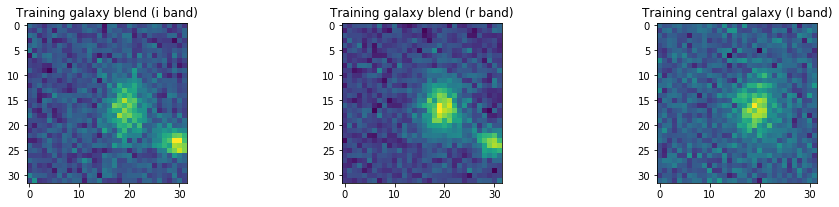

In [3]:
run_ident = 'test_3filter'

# Load data
path = os.path.join(os.path.dirname(os.getcwd()), "data")
filename = os.path.join(path, 'training_data.npz')
X_train, Y_train, X_val, Y_val = load_data(filename)
print('Train data input shape: ', X_train.shape)
print('Train data output shape: ', Y_train.shape)
print('Validation data input shape: ', X_val.shape)
print('Validation data output  shape: ', Y_val.shape)
plt.figure(figsize=[16,10])
plt.subplot(3,3,1)
plt.imshow(X_train[0,:,:,0])
plt.title('Training galaxy blend (i band)')
plt.subplot(3,3,2)
plt.imshow(X_train[0,:,:,1])
plt.title('Training galaxy blend (r band)')
plt.subplot(3,3,3)
plt.imshow(Y_train[0,:,:, 0])
plt.title('Training central galaxy (I band)')

In [4]:
# Load CNN deblender
model = utils.CNN_deblender(run_ident=run_ident)

# Run model
run_params = utils.Meas_args(epochs=10, batch_size=64)
train_loss, val_loss, pred = model.run_basic(X_train, Y_train,
                                             run_params, X_val, Y_val)
model.save()
model.sess.close()

Iteration 0: with minibatch training loss = 8.24443054199
Iteration 100: with minibatch training loss = 1.64229476452
Iteration 200: with minibatch training loss = 1.36589646339
Iteration 300: with minibatch training loss = 1.93533563614
Iteration 400: with minibatch training loss = 1.49790883064
Iteration 500: with minibatch training loss = 1.61559438705
Iteration 600: with minibatch training loss = 1.40831363201
Iteration 700: with minibatch training loss = 1.50056695938
Iteration 800: with minibatch training loss = 1.56572079659
Iteration 900: with minibatch training loss = 1.74452638626
Iteration 1000: with minibatch training loss = 1.67820930481
Iteration 1100: with minibatch training loss = 1.55960583687
Iteration 1200: with minibatch training loss = 1.58694636822
Iteration 1300: with minibatch training loss = 1.26388311386
Iteration 1400: with minibatch training loss = 1.27272152901
Iteration 1500: with minibatch training loss = 1.26786911488
Iteration 1600: with minibatch train

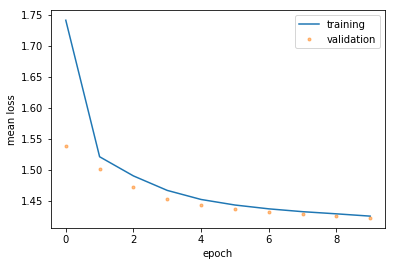

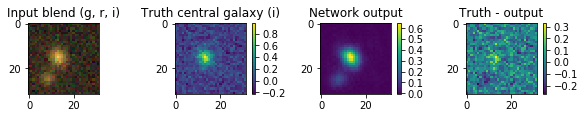

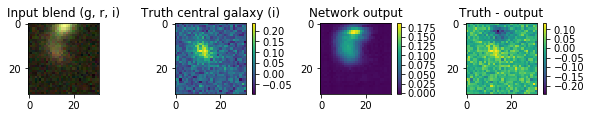

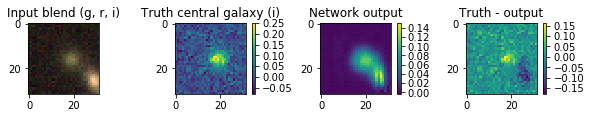

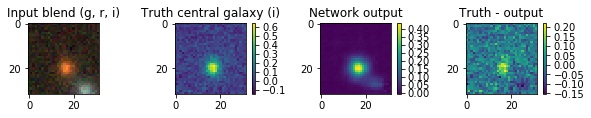

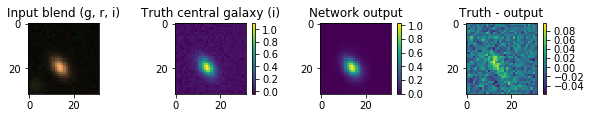

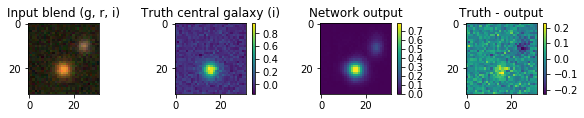

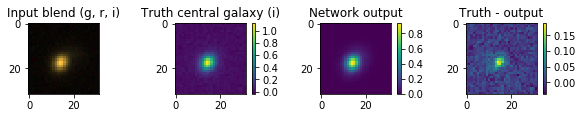

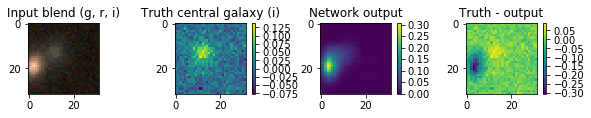

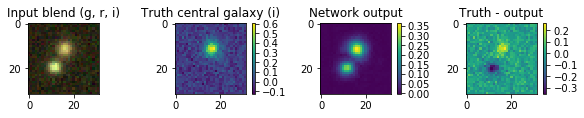

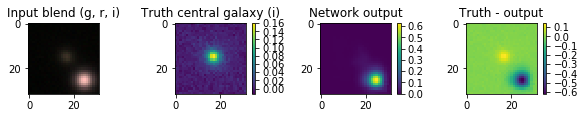

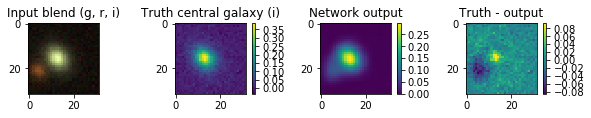

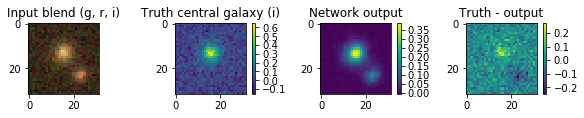

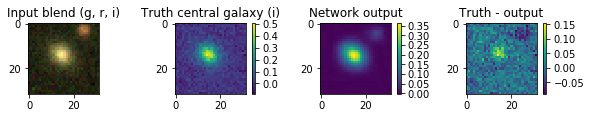

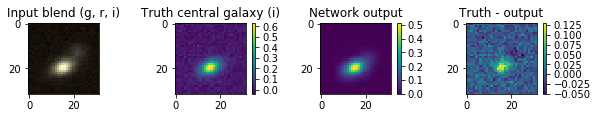

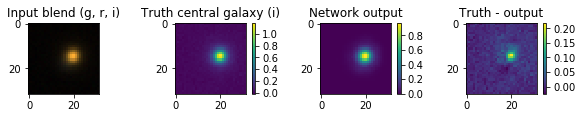

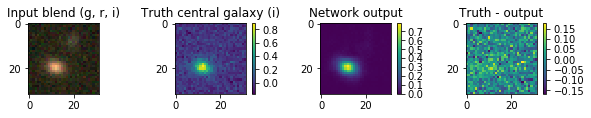

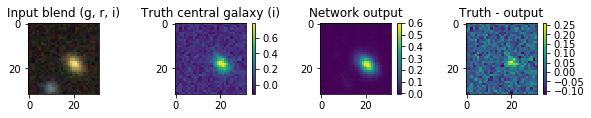

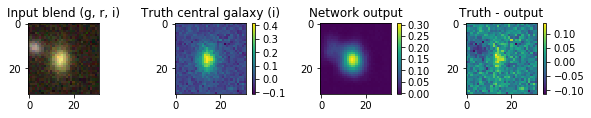

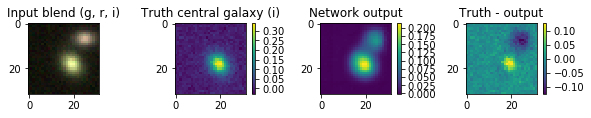

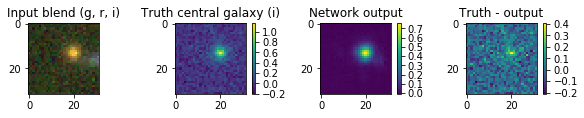

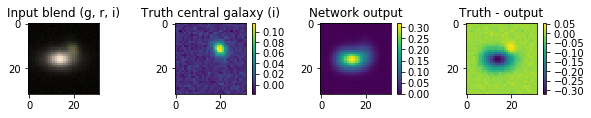

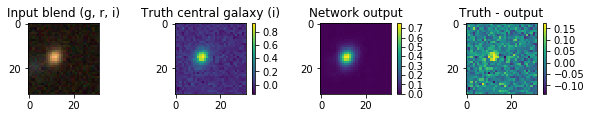

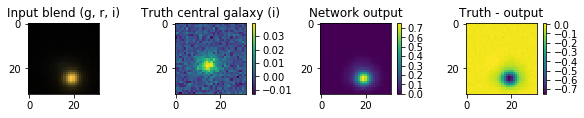

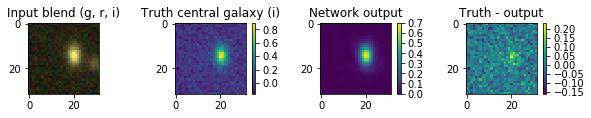

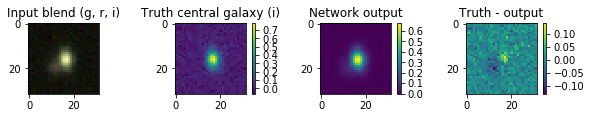

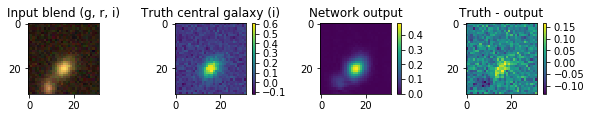

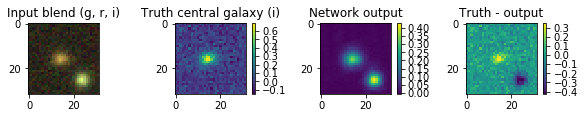

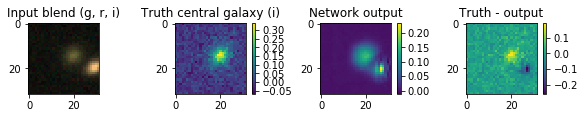

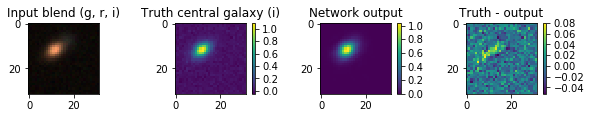

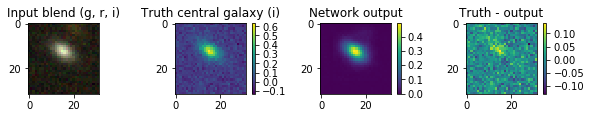

In [5]:
plt.plot(train_loss, label='training')
plt.plot(val_loss, '.', label='validation', alpha=0.5)
plt.ylabel('mean loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plot_preds(pred, X_val, Y_val)

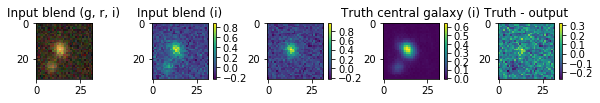

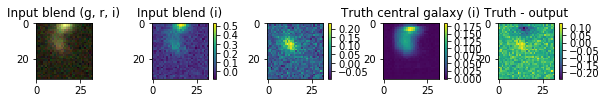

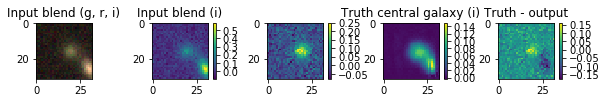

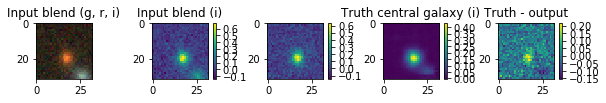

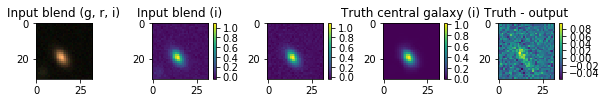

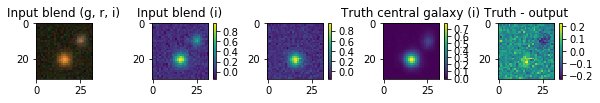

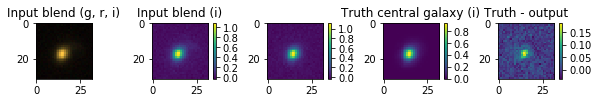

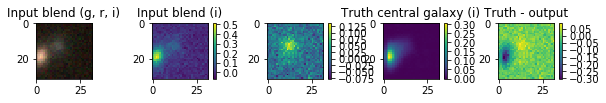

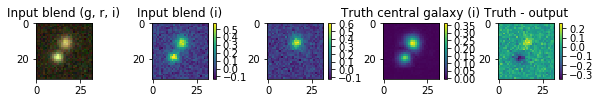

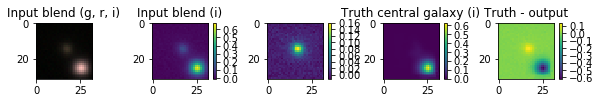

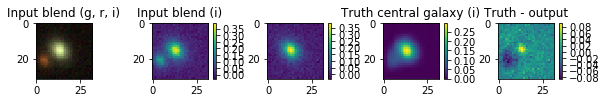

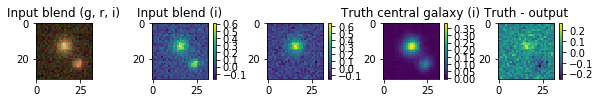

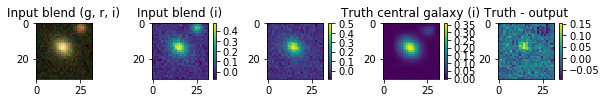

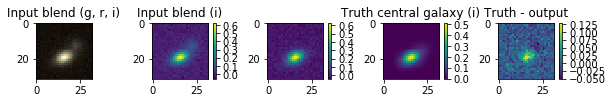

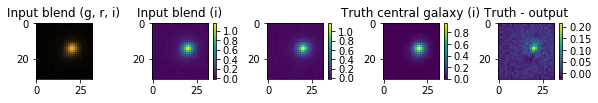

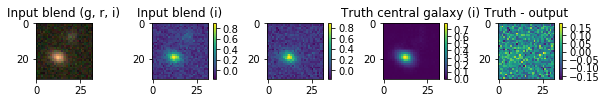

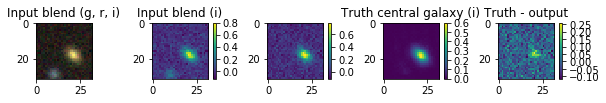

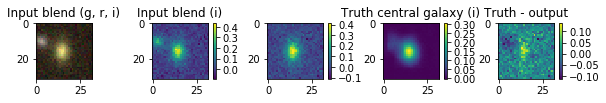

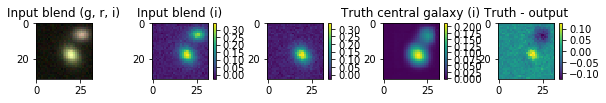

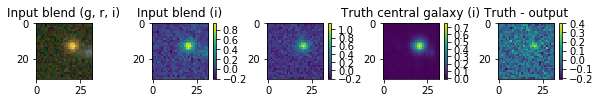

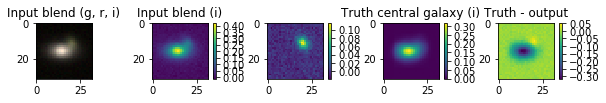

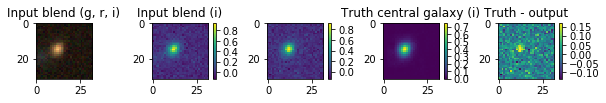

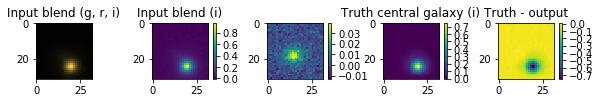

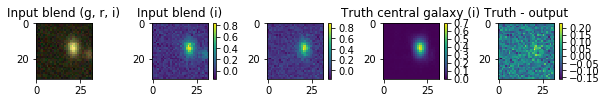

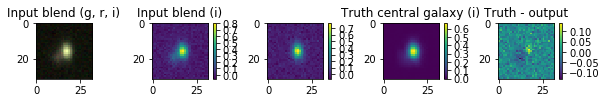

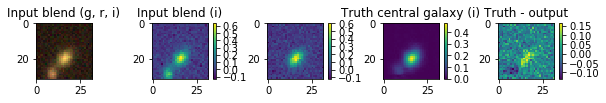

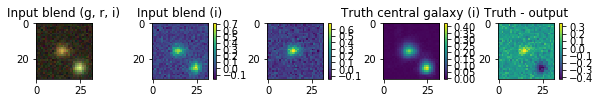

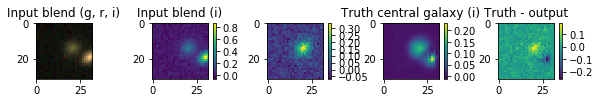

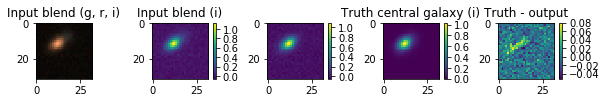

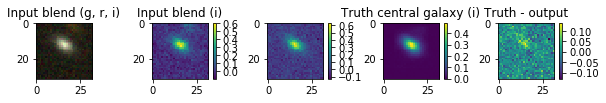

In [10]:
plot_preds(pred, X_val, Y_val)

(array([  8.00000000e+00,   1.20000000e+01,   2.05000000e+02,
          2.16000000e+03,   1.27570000e+04,   4.71280000e+04,
          1.29479000e+05,   2.66658000e+05,   1.78651000e+05,
          7.47000000e+02]),
 array([ 14.96543026,  16.46784067,  17.97025108,  19.4726615 ,
         20.97507191,  22.47748232,  23.97989273,  25.48230314,
         26.98471355,  28.48712397,  29.98953438]),
 <a list of 10 Patch objects>)

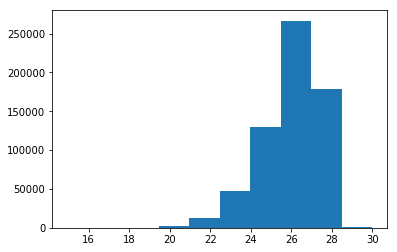

In [11]:
catdir = '/global/homes/s/sowmyak/blending'
fname = os.path.join(catdir, 'data', 'wldeb_data',
                     'OneDegSq.fits')
cat = Table.read(fname, format='fits')
a = np.hypot(cat['a_d'], cat['a_b'])
cond = (a <= 1.2) & (a > 0.2)
plt.hist(cat[cond]['i_ab'])

In [6]:
from astropy.table import Table
path = '/global/projecta/projectdirs/lsst/groups/WL/projects/wl-btf/two_gal_blend_data/training_data/'
path = os.path.join(os.path.dirname(os.getcwd()), "data")
filename = os.path.join(path, 'blend_param.tab')
blend_param = Table.read(filename, format='ascii')
diff_val = save_diff_blend(pred, Y_val)

np.random.seed(0)
validation = np.where(blend_param['is_validation'] ==1)
diff_val = diff_val[blend_param['nn_id'][validation]]

In [7]:
blend_param

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,distance_neighbor,mag_neighbor,color_neighbor,flux_neighbor,sigma_neighbor,is_validation,nn_id,norm
int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64
2201282044,2201282044,2,0,1,58,93,68,89,0.999205946922,0.000794025021605,-7484.78955078,-734.209899902,1.68259930611,23.7757053375,0.171590805054,219616.75,0.744857430458,0.824318349361,0.317551314831,0.0133926160634,1.03528106213,0.535905301571,0.0210748370737,0.993372797966,0.982210695744,37.5732917786,37.3877868652,37.3871955872,22.9538021088,22.3026657104,0.0548187047243,0.0476471148431,0.0383887067437,0.0565789975226,0.0484780147672,0.0395412668586,0.664824604988,0.572209358215,0.0241348184645,0.0,0.0,2.47245407104,24.5097846985,0.510080337524,111694.992188,0.252179503441,0,0,1008814.0
402700940002,402700940002,2,0,1,219,239,63,84,0.883918642998,0.116081364453,-7454.05419922,-735.188110352,0.766513586044,23.3710193634,0.993837356567,318815.8125,0.117214106023,0.160492733121,-0.520654678345,-0.182247042656,0.218049705029,0.0630092471838,-1.40244364738,0.638425767422,0.999894499779,102.804550171,100.346862793,100.346862793,61.2790412903,61.2752990723,0.347363740206,0.31568467617,0.140047743917,0.347402513027,0.315716445446,0.14006178081,0.367142260075,-0.841500997543,-0.294549524784,0.0,0.0,2.81623983383,24.1470680237,0.57434463501,155998.484375,0.216468513012,0,1,765962.0
402700655988,402700655988,2,0,1,362,393,61,91,0.516781032085,0.483218967915,-7424.39208984,-734.73236084,0.368888705969,22.8902931213,0.616619110107,496398.375,0.290784329176,0.291472971439,-0.0439516678452,-0.0208254959434,0.305288165808,0.276969522238,-1.34955084324,0.683589935303,0.994433104992,135.361999512,131.374908447,131.369552612,50.2665557861,48.4262695312,0.103421680629,0.0593863613904,0.0528995469213,0.106245957315,0.0601332113147,0.0543629303575,0.386473953724,-0.289051830769,-0.156246975064,0.0,0.0,2.39141464233,24.3156642914,0.479633331299,133561.6875,0.485251665115,0,2,1258610.0
402700865417,402700865417,2,0,1,510,533,66,91,1.0,0.0,-7395.61621094,-734.213928223,0.256251186132,23.3880519867,0.38240814209,313853.375,0.49951249361,0.523153483868,-0.13193154335,0.169715672731,0.621416926384,0.401522278786,1.11579203606,0.803983390331,0.898762047291,67.8437576294,67.1058731079,67.0564117432,42.6734008789,30.9745368958,0.0355445407331,0.0298458300531,0.0304887760431,0.0429082624614,0.0313175842166,0.0324319824576,0.536210596561,-0.250095039606,0.321618616581,0.0,0.0,2.22463512421,22.8945484161,0.659759521484,494456.65625,1.05346703529,0,3,1881260.0
402701084683,402701084683,2,0,1,669,691,67,92,1.0,0.0,-7363.90087891,-733.948303223,0.59226077795,23.6130409241,0.400468826294,255112.203125,0.540949940681,0.551337838173,-0.103250332177,-0.0914225876331,0.62148976326,0.470847338438,-1.20843851566,0.825491249561,0.970898926258,52.7724609375,52.3410568237,52.3392410278,32.9315757751,31.523891449,0.0424740724266,0.0368381179869,0.0366299599409,0.0440463609993,0.0379210226238,0.037496522069,0.557771146297,-0.200186431408,-0.177214160562,0.0,0.0,2.27924323082,24.0284099579,0.596397399902,174013.765625,0.257584512234,0,4,968638.0
2200544138,2200544138,2,0,1,816,840,57,96,0.977924108505,0.0220758970827,-7334.27929688,-734.60534668,0.865682125092,22.5887718201,0.764947891235,655298.0,0.616354644299,0.742436587811,-0.412793368101,-0.116605997086,0.974990606308,0.389637678862,-1.43314278126,0.918630480766,0.979754030704,127.630752563

In [20]:
diff_val.shape, blend_param

((2500,), <Table length=25000>
    db_id        grp_id    grp_size grp_rank ... is_validation nn_id    norm  
    int64        int64      int64    int64   ...     int64     int64  float64 
 ------------ ------------ -------- -------- ... ------------- ----- ---------
   2201282044   2201282044        2        0 ...             0     0  844536.0
 402700940002 402700940002        2        0 ...             0     1  621829.0
 402700655988 402700655988        2        0 ...             0     2 1081270.0
 402700865417 402700865417        2        0 ...             0     3  845723.0
 402701084683 402701084683        2        0 ...             0     4  665485.0
   2200544138   2200544138        2        0 ...             0     5 2018593.0
   2200408237   2200408237        2        0 ...             0     6 2328573.0
 402700655135 402700655135        2        0 ...             0     7 1218575.0
 402700162526 402700162526        2        0 ...             0     8 5512588.0
 402700503492 4027005

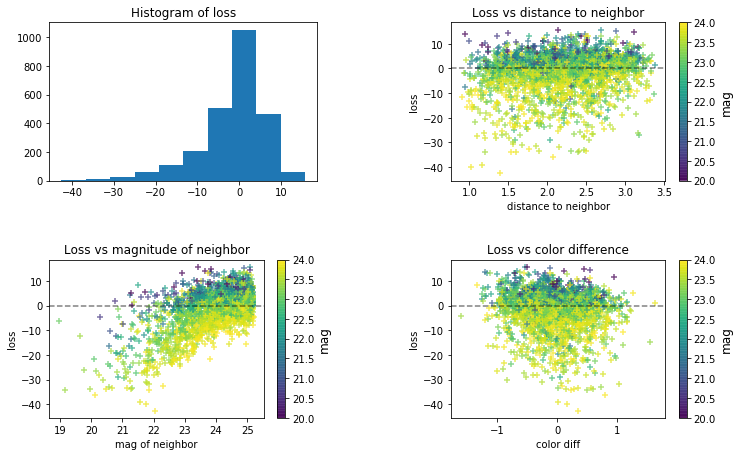

In [8]:
c = blend_param['ab_mag'][validation]

plt.figure(figsize=[12, 16])
plt.subplot(4, 2, 1)
plt.subplots_adjust(wspace = 0.5)
plt.subplots_adjust(hspace = 0.5)
plt.hist(diff_val)
plt.title("Histogram of loss")
plt.subplot(4, 2, 2)
plt.scatter(blend_param[validation]['distance_neighbor'], diff_val,
            c=c, vmin=20, vmax=24, alpha=0.7, marker='+')
cbar = plt.colorbar()
cbar.set_label(label='mag',size=12)
plt.title("Loss vs distance to neighbor")
plt.xlabel('distance to neighbor')
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.ylabel('loss')
plt.subplot(4, 2, 3)
plt.scatter(blend_param[validation]['mag_neighbor'], diff_val,
           c=c, vmin=20, vmax=24, alpha=0.7, marker='+')
cbar = plt.colorbar()
cbar.set_label(label='mag',size=12)
plt.title("Loss vs magnitude of neighbor")
plt.xlabel('mag of neighbor')
plt.ylabel('loss')
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.subplot(4, 2, 4)
plt.scatter(blend_param['color_neighbor'][validation] - blend_param['ri_color'][validation],
            diff_val, c=c, vmin=20, vmax=24, alpha=0.7, marker='+')
cbar = plt.colorbar()
cbar.set_label(label='mag',size=12)
plt.title("Loss vs color difference")
plt.xlabel('color diff')
plt.ylabel('loss')
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.show()

(array([  2.00000000e+00,   1.00000000e+01,   1.65000000e+02,
          1.09600000e+03,   4.63100000e+03,   1.19310000e+04,
          5.79600000e+03,   1.21500000e+03,   1.46000000e+02,
          8.00000000e+00]),
 array([-7.21875381, -5.73913841, -4.25952301, -2.77990761, -1.30029221,
         0.1793232 ,  1.6589386 ,  3.138554  ,  4.6181694 ,  6.09778481,
         7.57740021]),
 <a list of 10 Patch objects>)

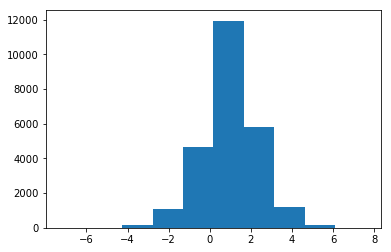

In [22]:
plt.hist(blend_param['mag_neighbor']-blend_param['ab_mag'])

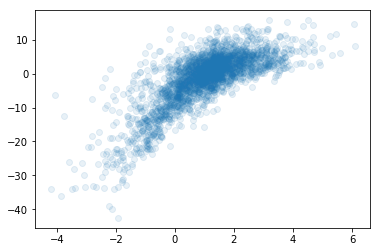

In [21]:
plt.scatter(blend_param['mag_neighbor'][validation]-blend_param['ab_mag'][validation], diff_val, alpha=0.1)